In [45]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

In [46]:
## define path to input datasets (tidy format)
path_to_recog = '/home/jefan/neurosketch/neurosketch_voxelmat_freesurfer_recog'
path_to_draw = '/home/jefan/neurosketch/neurosketch_voxelmat_freesurfer_drawing'
roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC'])

In [47]:
## get raw file list for recognition runs
RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='csv'])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='npy'])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [48]:
## get raw file list for drawing runs
DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='csv'])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='npy'])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [49]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
print 'Number of subs: {}'.format(len(sub_list))

Number of subs: 31


In [50]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

### How well do we do at classifying the target when we train on recognition patterns only?

In [522]:
#### Helper data loader functions
def load_draw_meta(this_sub):
    this_file = 'metadata_{}_drawing.csv'.format(this_sub)
    x = pd.read_csv(os.path.join(path_to_draw,this_file))
    x = x.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
    x['trial_num'] = np.repeat(np.arange(40),23)        
    return x
    
def load_draw_feats(this_sub,this_roi):
    this_file = '{}_{}_featurematrix.npy'.format(this_sub,this_roi)
    y = np.load(os.path.join(path_to_draw,this_file))
    y = y.transpose()
    return y

def load_draw_data(this_sub,this_roi):
    x = load_draw_meta(this_sub)
    y = load_draw_feats(this_sub,this_roi)
    assert y.shape[0] == x.shape[0]    
    return x,y

def load_recog_meta(this_sub,this_roi,this_phase):
    this_file = 'metadata_{}_{}_{}.csv'.format(this_sub,this_roi,this_phase)
    x = pd.read_csv(os.path.join(path_to_recog,this_file))
    x = x.drop(['Unnamed: 0'], axis=1)
    return x
    
def load_recog_feats(this_sub,this_roi,this_phase):
    this_file = '{}_{}_{}_featurematrix.npy'.format(this_sub,this_roi,this_phase)
    y = np.load(os.path.join(path_to_recog,this_file))
    y = y.transpose()
    return y    

def load_recog_data(this_sub,this_roi,this_phase):
    x = load_recog_meta(this_sub,this_roi,this_phase)
    y = load_recog_feats(this_sub,this_roi,this_phase)
    assert y.shape[0] == x.shape[0]    
    return x,y

# z-score normalization to de-mean & standardize variances within-voxel 
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

## plotting helper
def get_prob_timecourse(iv,DM):
    trained_objs = np.unique(DM.label.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]
    t1 = trained_objs[0]
    t2 = trained_objs[1]
    c1 = control_objs[0]
    c2 = control_objs[1]
    target = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(t1)].mean().values,
                   DM[DM.label==t2].groupby(iv)['{}_prob'.format(t2)].mean().values)).mean(0) ## target timecourse
    foil = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(t2)].mean().values,
                   DM[DM.label==t2].groupby(iv)['{}_prob'.format(t1)].mean().values)).mean(0) ## foil timecourse
    control = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(c1)].mean().values,
                        DM[DM.label==t1].groupby(iv)['{}_prob'.format(c2)].mean().values,
                        DM[DM.label==t2].groupby(iv)['{}_prob'.format(c1)].mean().values,
                        DM[DM.label==t2].groupby(iv)['{}_prob'.format(c2)].mean().values)).mean(0) ## control timecourse
    
    return target, foil, control
     
def flatten(x):
    return [item for sublist in x for item in sublist]    

In [ ]:
## general plotting params
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)


In [373]:
## example subject, roi, and phase (localizer is default)
this_sub = sub_list[0]
this_roi = roi_list[2] ## order is: ['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC']
this_phase = '12' ## options are '12', '34', '56'

In [441]:
ALLDM = []

## loop through all subjects and rois
Acc = []
for this_roi in roi_list:
    print this_roi
    acc = []
    for this_sub in sub_list:
        ## load subject data in
        RM12, RF12 = load_recog_data(this_sub,this_roi,'12')
        RM34, RF34 = load_recog_data(this_sub,this_roi,'34')        
        RM = pd.concat([RM12,RM34])
        RF = np.vstack((RF12,RF34))        
        DM, DF = load_draw_data(this_sub,this_roi)
        assert RF.shape[1]==DF.shape[1] ## that number of voxels is identical

        ## normalize voxels within task
        normalize_on = 1
        if normalize_on:
            _RF = normalize(RF)
            _DF = normalize(DF)
        else:
            _RF = RF
            _DF = DF

        # single train/test split
        X_train = _RF
        y_train = RM.label.values

        ## subset timepoints?
        inds = DM.time_point>0
        _DF = _DF[inds,:]
        DM = DM[DM.time_point>0]

        X_test = _DF
        y_test = DM.label.values
        # clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
        clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)    

        ## add prediction probabilities to metadata matrix
        cats = clf.classes_
        probs = clf.predict_proba(X_test)
        DM['bed_prob'] = probs[:,0]
        DM['bench_prob'] = probs[:,1]
        DM['chair_prob'] = probs[:,2]
        DM['table_prob'] = probs[:,3]
        
        DM['subj'] = np.repeat(this_sub,DM.shape[0])
        DM['roi'] = np.repeat(this_roi,DM.shape[0])
        
        if len(ALLDM)==0:
            ALLDM = DM
        else:
            ALLDM = pd.concat([ALLDM,DM],ignore_index=True)

        ## plot probability timecourse
        fig = plt.figure(figsize=(5,5))
        iv = 'run_num'
        t,f,c = get_prob_timecourse(iv,DM)
        plt.plot(t,color=colors[0],label='target')
        plt.plot(f,color=colors[1],label='foil')
        plt.plot(c,color=colors[2],label='control')
        plt.legend(bbox_to_anchor=(1.45, 1.01))
        plt.ylim(0,1)
        plt.xlabel(iv)
        plt.ylabel('probability')
        if not os.path.exists('./plots/subj'):
            os.makedirs('./plots/subj')
        plt.tight_layout()
        plt.savefig('./plots/subj/{}_{}_prob_{}.pdf'.format(iv.split('_')[0],this_roi,this_sub))
        plt.close(fig)

        acc.append(clf.score(X_test, y_test))
    Acc.append(acc)

V1
V2
LOC
IT
fusiform
parahippo
PRC
ento
hipp
mOFC


In [ ]:
ALLDM = ALLDM.drop(['Unnamed: 0.1.1'],axis=1)

In [769]:
Acc = np.array(Acc)
x = pd.DataFrame(Acc.transpose())
x.columns = roi_list

(0, 0.35)

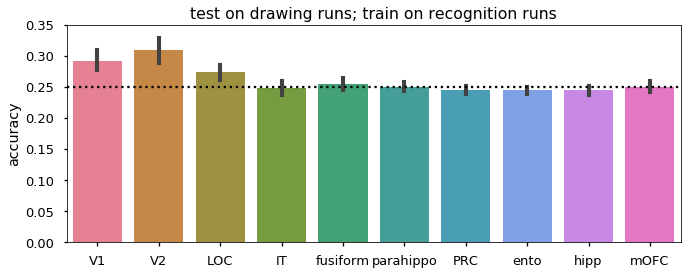

In [771]:
sns.set_context('talk')
plt.figure(figsize=(11,4))
sns.barplot(data=x,palette='husl',ci=95)
plt.axhline(0.25,linestyle=':',color='k')
plt.ylabel('accuracy')
plt.title('test on drawing runs; train on recognition runs')
plt.ylim(0,0.35)

In [455]:
ALLDM.head()

,TR_num,bed_prob,bench_prob,chair_prob,label,roi,run_num,subj,table_prob,time_point,trial_num
0,10,0.785917,0.013764,0.010464,bed,V1,1,0110171,0.189855,1,0
1,11,0.943448,0.012615,0.012706,bed,V1,1,0110171,0.031231,2,0
2,12,0.223766,0.118172,0.020711,bed,V1,1,0110171,0.637351,3,0
3,13,0.018425,0.429318,0.000032,bed,V1,1,0110171,0.552225,4,0
4,14,0.399308,0.000777,0.054215,bed,V1,1,0110171,0.545701,5,0


In [645]:
sns.set_context('paper')
this_roi = 'V1'
subs = np.unique(ALLDM.subj.values)
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
ivs = ['run_num','trial_num','time_point']
this_iv = 'time_point'

## do you want to render the CONDITION-wise plots -- trained vs. foil vs control
## or the DIFFERENCE plots -- trained - foil vs foil - control?
render_cond = 0

for this_iv in ivs:
    for this_roi in roi_list:

        T = []
        F = []
        C = []
        Sub = []
        for sub in subs:
            inds =(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) 
            t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])
            if len(T)==0:
                T = t
                F = f
                C = c
                DTF = t-f                
                DTC = t-c
                DFC = f-c
            else:
                T = np.hstack((T,t))
                F = np.hstack((F,f))        
                C = np.hstack((C,c)) 
                DTF = np.hstack((DTF,t-f))                
                DTC = np.hstack((DTC,t-c))
                DFC = np.hstack((DFC,f-c))
            Sub.append([sub]*len(t))   
          
        if render_cond==1:
            ## make longform version of dataframe to use in tsplot (by condition)            
            Trial = np.tile(np.arange(len(t)),len(subs)*3)
            Condition = np.repeat(['trained','foil','control'],len(T))
            Sub = np.tile(np.array(flatten(Sub)),3)
            Prob = np.hstack((T,F,C))
            assert len(Trial)==len(Condition)
            assert len(Sub)==len(Prob)
            assert len(Condition)==len(Sub)
            x = pd.DataFrame([Prob,Trial,Condition,Sub])
            x = x.transpose()
            x.columns = ['probability',lookup[this_iv],'condition','sub']
            toop = 'condition'            
        else:
            ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
            Trial = np.tile(np.arange(len(t)),len(subs)*3)
            Condition = np.repeat(['trained-foil','trained-control','foil-control'],len(T))
            Sub = np.tile(np.array(flatten(Sub)),3)
            Prob = np.hstack((DTF,DTC,DFC))        
            assert len(Trial)==len(Condition)
            assert len(Sub)==len(Prob)
            assert len(Condition)==len(Sub)
            x = pd.DataFrame([Prob,Trial,Condition,Sub])
            x = x.transpose()
            x.columns = ['probability',lookup[this_iv],'condition','sub']        
            toop = 'difference'
        fig = plt.figure(figsize=(8,4))
        ## plot it
        sns.tsplot(data=x,
                  time=lookup[this_iv],
                  unit='sub',
                  condition='condition',
                  value='probability',
                  ci=95)
        if render_cond==1:
            plt.ylim(0,0.5)
            plt.axhline(0.25,linestyle=':',color='k')  
            plt.legend(bbox_to_anchor=(0.8, 1.01))  
            plt.title('Classifier evidence by condition in {}'.format(this_roi))
            
        else:
            plt.ylim(-0.3,0.3)
            plt.axhline(0,linestyle=':',color='k')  
            plt.legend(bbox_to_anchor=(0.7, 1.01))                        
            plt.title('Difference in classifier evidence by condition in {}'.format(this_roi))        
        plt.xticks(np.arange(np.max(x[lookup[this_iv]].values)+1))
        if not os.path.exists('./plots/roi/{}/{}'.format(lookup[this_iv],toop)):
            os.makedirs('./plots/roi/{}/{}'.format(lookup[this_iv],toop))
        plt.tight_layout()        
        plt.savefig('./plots/roi/{}/{}/prob_timecourse_{}_by_{}.pdf'.\
                    format(lookup[this_iv],toop,this_roi,lookup[this_iv]))
        plt.close(fig)

In [661]:
## get subject-level index of contrast between objects during drawing
sub_tf = []
sub_tc = []
sub_fc = []
roi = []

subs = np.unique(ALLDM.subj.values)
ivs = ['time_point'] ## other optoins 'run_num','trial_num',

## do you want to render the CONDITION-wise plots -- trained vs. foil vs control
## or the DIFFERENCE plots -- trained - foil vs foil - control?
render_cond = 0

for this_iv in ivs:
    for this_roi in roi_list:

        T = []
        F = []
        C = []
        Sub = []
        for sub in subs:
            inds =(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) 
            t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])
            if len(T)==0:
                T = t
                F = f
                C = c
                DTF = t-f                
                DTC = t-c
                DFC = f-c
            else:
                T = np.hstack((T,t))
                F = np.hstack((F,f))        
                C = np.hstack((C,c)) 
                DTF = np.hstack((DTF,t-f))                
                DTC = np.hstack((DTC,t-c))
                DFC = np.hstack((DFC,f-c))
            Sub.append([sub]*len(t))   
          
        ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
        Trial = np.tile(np.arange(len(t)),len(subs)*3)
        Condition = np.repeat(['trained-foil','trained-control','foil-control'],len(T))
        Sub = np.tile(np.array(flatten(Sub)),3)
        Prob = np.hstack((DTF,DTC,DFC))        
        assert len(Trial)==len(Condition)
        assert len(Sub)==len(Prob)
        assert len(Condition)==len(Sub)
        x = pd.DataFrame([Prob,Trial,Condition,Sub])
        x = x.transpose()
        x.columns = ['probability',lookup[this_iv],'condition','sub']
        
        for this_sub in subs:
            sub_tf.append(x[(x['condition']=='trained-foil') & (x['sub']==this_sub)]['probability'].mean())
            sub_tc.append(x[(x['condition']=='trained-control') & (x['sub']==this_sub)]['probability'].mean())  
            sub_fc.append(x[(x['condition']=='foil-control') & (x['sub']==this_sub)]['probability'].mean()) 
            roi.append(this_roi)
            
## make dataframe with subject-level difference scores
d = pd.DataFrame([sub_tf,sub_tc,sub_fc,roi])
d = d.transpose()
d.columns = ['trained-foil','trained-control','foil-control','roi']

In [703]:
for this_roi in roi_list:
    data = d[d['roi']==this_roi]['trained-foil']
    t,p = stats.ttest_1samp(data,0)
    print 'ROI = {} | t = {}, p = {}'.format(this_roi,t,p)

ROI = V1 | t = 6.06284294265, p = 1.16981190933e-06
ROI = V2 | t = 7.01811461948, p = 8.44558093155e-08
ROI = LOC | t = 5.68683522619, p = 3.35542978998e-06
ROI = IT | t = 0.267350750097, p = 0.79102855213
ROI = fusiform | t = 3.11951408338, p = 0.00398133191828
ROI = parahippo | t = 0.221886976194, p = 0.825905427007
ROI = PRC | t = -0.567728475448, p = 0.574444014979
ROI = ento | t = -1.20910238074, p = 0.236066694533
ROI = hipp | t = -1.09984706193, p = 0.280146487235
ROI = mOFC | t = -1.20973191311, p = 0.235828526502


In [704]:
for this_roi in roi_list:
    data = d[d['roi']==this_roi]['trained-control']
    t,p = stats.ttest_1samp(data,0)
    print 'ROI = {} | t = {}, p = {}'.format(this_roi,t,p)

ROI = V1 | t = 4.01166188947, p = 0.000369797686373
ROI = V2 | t = 4.88954067068, p = 3.18194121883e-05
ROI = LOC | t = 2.95824340698, p = 0.00598517443678
ROI = IT | t = -0.293096003732, p = 0.771466671399
ROI = fusiform | t = 0.88937032223, p = 0.380880502125
ROI = parahippo | t = -0.372822616005, p = 0.711901698352
ROI = PRC | t = -1.18012447434, p = 0.247223978943
ROI = ento | t = -1.15776105692, p = 0.256096250404
ROI = hipp | t = -0.836858971361, p = 0.409288897498
ROI = mOFC | t = 0.295400877733, p = 0.769722581309


In [705]:
for this_roi in roi_list:
    data = d[d['roi']==this_roi]['foil-control']
    t,p = stats.ttest_1samp(data,0)
    print 'ROI = {} | t = {}, p = {}'.format(this_roi,t,p)

ROI = V1 | t = -5.88359110942, p = 1.93128733938e-06
ROI = V2 | t = -7.39322246814, p = 3.08502466511e-08
ROI = LOC | t = -3.56844652222, p = 0.00123075380322
ROI = IT | t = -0.546189209788, p = 0.588975136437
ROI = fusiform | t = -2.38067131112, p = 0.0238320596525
ROI = parahippo | t = -0.567486700699, p = 0.574606130959
ROI = PRC | t = -0.403935403148, p = 0.689125335114
ROI = ento | t = 0.0886136748636, p = 0.92997785654
ROI = hipp | t = 0.0421122599135, p = 0.966688243612
ROI = mOFC | t = 1.12702678992, p = 0.26866534705


In [706]:
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')

In [758]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']
this_roi = 'hipp'

for this_roi in roi_list:
    draw = d[d['roi']==this_roi]['trained-control'].values - d[d['roi']==this_roi]['foil-control'].values
    recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values

    z = pd.DataFrame([draw,recog])
    z = z.transpose()
    z.columns=['draw','recog']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="draw",
                y ="recog",
                data=z)
    r,p = stats.pearsonr(draw,recog)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,3),np.round(p,3)))
    if not os.path.exists('./plots/roi/drawrecog'):
        os.makedirs('./plots/roi/drawrecog')
    plt.tight_layout()
    plt.savefig('./plots/roi/drawrecog/draw_recog_scatter_{}.pdf'.format(this_roi))
    plt.close(fig)    
    

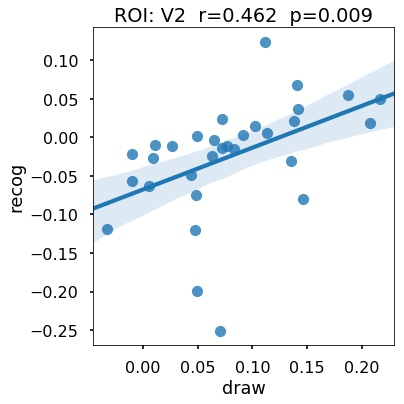

In [767]:
this_roi = 'V2'
draw = d[d['roi']==this_roi]['trained-control'].values - d[d['roi']==this_roi]['foil-control'].values
recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values

z = pd.DataFrame([draw,recog])
z = z.transpose()
z.columns=['draw','recog']

## plot 
fig = plt.figure(figsize=(6,6))
sns.set_context('poster')
sns.regplot(x="draw",
            y ="recog",
            data=z)
r,p = stats.pearsonr(draw,recog)
plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,3),np.round(p,3)))
if not os.path.exists('./plots/roi/drawrecog'):
    os.makedirs('./plots/roi/drawrecog')
plt.tight_layout()
# plt.savefig('./plots/roi/drawrecog/draw_recog_scatter_{}.pdf'.format(this_roi))
# plt.close(fig)  